In [1]:
import torch
import torch.nn as nn
from functools import partial
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/root/miniconda3/envs/ebm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([10000, 1])


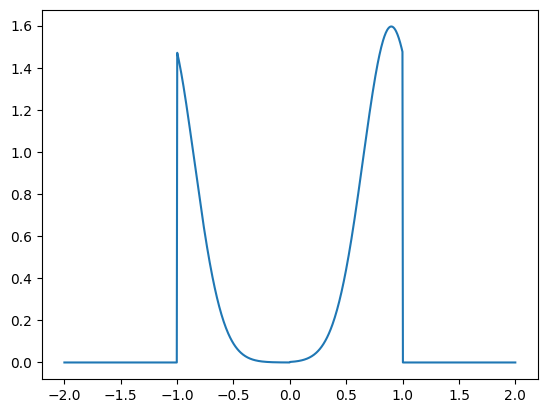

In [2]:
def density(data_name):
    def f(x):
        if data_name=="Gaussian":
            return 4/torch.sqrt(torch.tensor(2*torch.pi))*torch.exp(-8*x**2)
        elif data_name=="Uniform":
            return torch.where((x<0.5)&(x>-0.5), 1, 0)
        elif data_name=="Gaussian2":
            return 2.5/torch.sqrt(torch.tensor(2*torch.pi))*torch.exp(-12.5*(x+0.4)**2) + 4/torch.sqrt(torch.tensor(2*torch.pi))*torch.exp(-32*(x-0.5)**2)
        elif data_name=="Uniform2":
            return torch.where(((x>0.4)&(x<0.9))|((x<-0.4)&(x>-0.9)), 1, 0)
        elif data_name=="marginal":
            return torch.where((x<1)&(x>-1), 4/torch.sqrt(torch.tensor(2*torch.pi))*torch.exp(-8*(x%2-0.9)**2), 0)
        else:
            raise NotImplementedError
    return f

def mse_loss(net, f):
    samples = torch.rand(10000, 1).to(device) * 4 - 2
    integral = torch.mean(torch.exp(-net(samples)))*4
    x = torch.rand(10000, 1).to(device) * 4 - 2
    ground_truth = f(x)
    pred = torch.exp(-net(x))/integral
    return torch.mean((ground_truth-pred)**2)

f = density('marginal')
x = torch.linspace(-2, 2, 1000)
sample = torch.randn(10000, 1)/4+0.9
sample = torch.where(sample<1, sample, sample-2)
print(sample.shape)
plt.plot(x, f(x))

In [3]:
class MLP(nn.Module):
    def __init__(self, input_dim:int, hidden_dim:int, hidden_depth:int, output_dim:int, dropout:float) -> None:
        super().__init__()
        dropout_layer = partial(nn.Dropout, p=dropout)
        layers1 = [nn.Linear(input_dim, hidden_dim), nn.ReLU(), dropout_layer()]
        for _ in range(hidden_depth-1):
            layers1 += [nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), dropout_layer()]
        layers1.append(nn.Linear(hidden_dim, output_dim))
        self.layers1 = nn.Sequential(*layers1)
    def forward(self, x):
        return self.layers1(x)

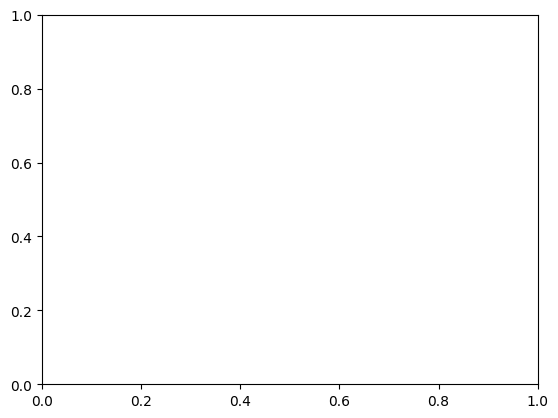

In [6]:
from tqdm import tqdm
fig, ax = plt.subplots()

def reflact(tensor, down, up):
    t = tensor.clone()
    while ((down<t) & (t>up)).any():   
        t = torch.where(t<down, 2*down-t, t)
        t = torch.where(t>up, 2*up-t, t)
    return t

def energy_discrepancy(energy_net, x, margin, m_particles=16, t_noise=0.5, w_stable=1.0):
    device = x.device
    browniani = torch.randn_like(x).to(device) * t_noise
    brownianij = torch.randn(x.size(0), m_particles, *x.shape[1:]).to(device) * t_noise
    pert_data_origin = x.unsqueeze(1) + browniani.unsqueeze(1) + brownianij
    if margin=='clip':
        pert_data = torch.clip(pert_data_origin, -1, 1)
    elif margin=='reflact':
        pert_data = reflact(pert_data_origin, -1, 1)
    else:
        pert_data = pert_data_origin
    pos_energy = energy_net(x=x)
    neg_energy = energy_net(x=pert_data)
    val = pos_energy - neg_energy.squeeze()
    if w_stable != 0:
        val = torch.cat([val, np.log(w_stable) * torch.ones_like(val[:, :1])], dim=-1)
    loss = val.logsumexp(dim=-1).mean()
    return loss, pos_energy.max(), neg_energy.max()

def energy_discrepancy_train(energy_net, f, margin, data_name, m_particles=16, t_noise=0.5, w_stable=1.0, epochs=1000, batch_size=256):
    optimizer = torch.optim.Adam(energy_net.parameters(), lr=0.01)
    pbar = tqdm(range(epochs))
    f = density('marginal')
    for epoch in pbar:
        ED = 0.0
        energy_net.train()
        if data_name=='Gaussian':
            x = torch.randn(batch_size, 1).to(device)/4
        elif data_name=='Gaussian2':
            Bo = torch.where(torch.rand(batch_size, 1)<0.5, 0, 1)
            x = (torch.randn(batch_size, 1)/5-0.4)*Bo + (torch.randn(batch_size, 1)/8+0.5)*(1-Bo)
            x = x.to(device)
        elif data_name=='Uniform':
            x = torch.rand(batch_size, 1).to(device)-0.5
        elif data_name=='Uniform2':
            Bo = torch.where(torch.rand(batch_size, 1)<0.5, 0, 1).to(device)
            x = (torch.rand(batch_size, 1).to(device)/2+0.4)*Bo+(torch.rand(batch_size, 1).to(device)/2-0.9)*(1-Bo)
        elif data_name=="marginal":
            x = torch.randn(10000, 1).to(device)/4+0.9
            x = torch.where(x<1, x, x-2)
        loss, _, _ = energy_discrepancy(energy_net, x, margin, m_particles, t_noise, w_stable)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ED += loss
        energy_net.eval()
        test_loss = mse_loss(energy_net, f)
        writer.add_scalar(f"{margin}_t_noise_{t_noise}_w_{w_stable}/ED", ED.item(), epoch)
        writer.add_scalar(f"{margin}_t_noise_{t_noise}_w_{w_stable}/MSE", test_loss.item(), epoch)  
        writer.add_scalar(f"{margin}_t_noise_{t_noise}_w_{w_stable}/MSE_log", torch.log(test_loss).item(), epoch)  
        pbar.set_description('Epoch:{:4d},ED:{:.4f},MSE:{:.4f}'.format(epoch, loss.item(), test_loss.item()))
    x = torch.linspace(-2, 2, 1000)[..., None].to(device)
    samples = torch.rand(10000, 1).to(device) * 4 - 2
    integral = torch.mean(torch.exp(-energy_net(samples))).item()*4
    ax.cla()
    ax.plot(x.cpu().detach().numpy(), np.exp(-energy_net(x).cpu().detach().numpy())/integral, label='predict')
    ax.plot(x.cpu().detach().numpy(), f(x).cpu().detach().numpy(), label='ground_truth')
    ax.legend(loc='best')
    writer.add_figure(f"{margin}_t_noise_{t_noise}_w_{w_stable}/result",fig)

In [7]:
for margin in [None]:
    for t_noise in range(5):
        for w in [0.0, 0.1, 0.5, 1.0, 2.0]:
            net = MLP(1, 256, 3, 1, 0.1).to(device)
            print("margin:{}, t_noise:{}, w:{}".format(margin, 2**t_noise*0.1, w))
            energy_discrepancy_train(net, f, margin, data_name='marginal', m_particles=16, t_noise=2**t_noise*0.1, w_stable=w, epochs=5000, batch_size=512)

margin:None, t_noise:0.1, w:0.0


Epoch:4999,ED:2.7722,MSE:0.1958: 100%|██████████| 5000/5000 [01:27<00:00, 56.87it/s]  


margin:None, t_noise:0.1, w:0.1


Epoch:4999,ED:2.4470,MSE:0.0141: 100%|██████████| 5000/5000 [01:27<00:00, 56.84it/s]


margin:None, t_noise:0.1, w:0.5


Epoch:4999,ED:2.5025,MSE:0.0023: 100%|██████████| 5000/5000 [01:27<00:00, 57.20it/s]


margin:None, t_noise:0.1, w:1.0


Epoch:4999,ED:2.5445,MSE:0.0024: 100%|██████████| 5000/5000 [01:28<00:00, 56.61it/s]


margin:None, t_noise:0.1, w:2.0


Epoch:4999,ED:2.6323,MSE:0.0068: 100%|██████████| 5000/5000 [01:29<00:00, 56.00it/s]


margin:None, t_noise:0.2, w:0.0


Epoch:4999,ED:-3518607872.0000,MSE:0.1634: 100%|██████████| 5000/5000 [01:29<00:00, 56.13it/s]


margin:None, t_noise:0.2, w:0.1


Epoch:4999,ED:2.0770,MSE:0.0051: 100%|██████████| 5000/5000 [01:29<00:00, 56.14it/s]


margin:None, t_noise:0.2, w:0.5


Epoch:4999,ED:2.1779,MSE:0.0051: 100%|██████████| 5000/5000 [01:29<00:00, 56.06it/s]


margin:None, t_noise:0.2, w:1.0


Epoch:4999,ED:2.2517,MSE:0.0016: 100%|██████████| 5000/5000 [01:27<00:00, 56.89it/s]


margin:None, t_noise:0.2, w:2.0


Epoch:4999,ED:2.3759,MSE:0.0188: 100%|██████████| 5000/5000 [01:27<00:00, 57.06it/s]


margin:None, t_noise:0.4, w:0.0


Epoch:4999,ED:-56626388992.0000,MSE:0.1608: 100%|██████████| 5000/5000 [01:28<00:00, 56.46it/s]


margin:None, t_noise:0.4, w:0.1


Epoch:4999,ED:1.5882,MSE:0.0012: 100%|██████████| 5000/5000 [01:29<00:00, 56.11it/s]


margin:None, t_noise:0.4, w:0.5


Epoch:4999,ED:1.7273,MSE:0.0036: 100%|██████████| 5000/5000 [01:28<00:00, 56.42it/s]


margin:None, t_noise:0.4, w:1.0


Epoch:4999,ED:1.8554,MSE:0.0036: 100%|██████████| 5000/5000 [01:28<00:00, 56.70it/s]


margin:None, t_noise:0.4, w:2.0


Epoch:4999,ED:2.0253,MSE:0.0028: 100%|██████████| 5000/5000 [01:28<00:00, 56.71it/s]


margin:None, t_noise:0.8, w:0.0


Epoch:4999,ED:-538778402816.0000,MSE:0.1558: 100%|██████████| 5000/5000 [01:29<00:00, 55.98it/s]


margin:None, t_noise:0.8, w:0.1


Epoch:4999,ED:1.1685,MSE:0.0047: 100%|██████████| 5000/5000 [01:28<00:00, 56.76it/s]


margin:None, t_noise:0.8, w:0.5


Epoch:4999,ED:1.3973,MSE:0.0013: 100%|██████████| 5000/5000 [01:28<00:00, 56.81it/s]


margin:None, t_noise:0.8, w:1.0


Epoch:4999,ED:1.5476,MSE:0.0024: 100%|██████████| 5000/5000 [01:29<00:00, 55.98it/s]


margin:None, t_noise:0.8, w:2.0


Epoch:4999,ED:1.7811,MSE:0.0104: 100%|██████████| 5000/5000 [01:28<00:00, 56.48it/s]


margin:None, t_noise:1.6, w:0.0


Epoch:4999,ED:-3074465202176.0000,MSE:nan: 100%|██████████| 5000/5000 [01:28<00:00, 56.52it/s]
/tmp/ipykernel_1335/862957538.py:66: RuntimeWarning: overflow encountered in exp
  ax.plot(x.cpu().detach().numpy(), np.exp(-energy_net(x).cpu().detach().numpy())/integral, label='predict')
/tmp/ipykernel_1335/862957538.py:66: RuntimeWarning: invalid value encountered in divide
  ax.plot(x.cpu().detach().numpy(), np.exp(-energy_net(x).cpu().detach().numpy())/integral, label='predict')


margin:None, t_noise:1.6, w:0.1


Epoch:4999,ED:0.5791,MSE:0.0101: 100%|██████████| 5000/5000 [01:28<00:00, 56.52it/s]


margin:None, t_noise:1.6, w:0.5


Epoch:4999,ED:0.9238,MSE:0.0047: 100%|██████████| 5000/5000 [01:27<00:00, 57.20it/s]


margin:None, t_noise:1.6, w:1.0


Epoch:4999,ED:1.1802,MSE:0.0019: 100%|██████████| 5000/5000 [01:27<00:00, 56.88it/s]


margin:None, t_noise:1.6, w:2.0


Epoch:4999,ED:1.4850,MSE:0.0047: 100%|██████████| 5000/5000 [01:28<00:00, 56.58it/s]


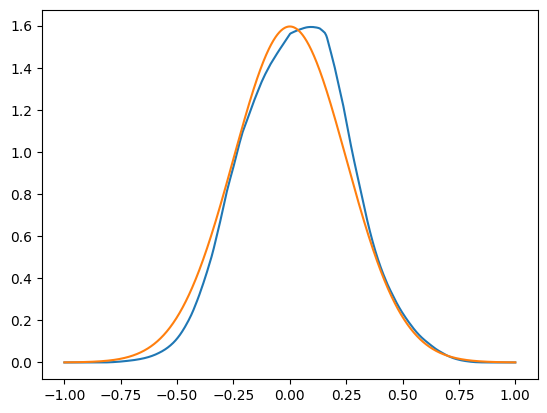

In [ ]:
import matplotlib.pyplot as plt
x = torch.linspace(-1, 1, 1000)[..., None]
net = net.cpu()
samples = torch.rand(10000, 1) * 2 - 1
integral = torch.mean(torch.exp(-net(samples))).item()*2
plt.plot(x.detach().numpy(), np.exp(-net(x).detach().numpy())/integral)
plt.plot(x.detach().numpy(), f(x).detach().numpy())

In [ ]:
from tqdm import tqdm
fig, ax = plt.subplots()

def reflact(tensor, down, up):
    t = tensor.clone()
    while ((down<t) & (t>up)).any():   
        t = torch.where(t<down, 2*down-t, t)
        t = torch.where(t>up, 2*up-t, t)
    return t

def energy_discrepancy_cond(energy_net, x, cond, margin, m_particles=16, t_noise=0.5, w_stable=1.0):
    device = x.device
    browniani = torch.randn_like(x).to(device) * t_noise
    brownianij = torch.randn(x.size(0), m_particles, *x.shape[1:]).to(device) * t_noise
    pert_data_origin = x.unsqueeze(1) + browniani.unsqueeze(1) + brownianij
    if margin=='clip':
        pert_data = torch.clip(pert_data_origin, -1, 1)
    elif margin=='reflact':
        pert_data = reflact(pert_data_origin, -1, 1)
    pos_energy = energy_net(x=x)
    neg_energy = energy_net(x=pert_data)
    val = pos_energy - neg_energy.squeeze()
    if w_stable != 0:
        val = torch.cat([val, np.log(w_stable) * torch.ones_like(val[:, :1])], dim=-1)
    loss = val.logsumexp(dim=-1).mean()
    return loss, pos_energy.max(), neg_energy.max()

def energy_discrepancy_train(energy_net, f, margin, data_name, m_particles=16, t_noise=0.5, w_stable=1.0, epochs=1000, batch_size=256):
    optimizer = torch.optim.Adam(energy_net.parameters(), lr=0.01)
    pbar = tqdm(range(epochs))
    for epoch in pbar:
        ED = 0.0
        energy_net.train()
        if data_name=='Gaussian':
            x = torch.randn(batch_size, 1).to(device)/4
        elif data_name=='Gaussian2':
            Bo = torch.where(torch.rand(batch_size, 1)<0.5, 0, 1)
            x = (torch.randn(batch_size, 1).to(device)/8-0.5)*Bo + (torch.randn(batch_size, 1).to(device)/8-0.5)*(1-Bo)
        elif data_name=='Uniform':
            x = torch.rand(batch_size, 1).to(device)-0.5
        elif data_name=='Uniform2':
            Bo = torch.where(torch.rand(batch_size, 1)<0.5, 0, 1)
            x = (torch.rand(batch_size, 1).to(device)/2+0.25)*Bo+(torch.rand(batch_size, 1).to(device)/2-0.75)*(1-Bo)
        loss, _, _ = energy_discrepancy(energy_net, x, margin, m_particles, t_noise, w_stable)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ED += loss
        energy_net.eval()
        test_loss = mse_loss(energy_net, f)
        writer.add_scalar(f"{margin}_t_noise_{t_noise}_w_{w_stable}/ED", ED.item(), epoch)
        writer.add_scalar(f"{margin}_t_noise_{t_noise}_w_{w_stable}/MSE", test_loss.item(), epoch)  
        writer.add_scalar(f"{margin}_t_noise_{t_noise}_w_{w_stable}/MSE_log", torch.log(test_loss).item(), epoch)  
        pbar.set_description('Epoch:{:4d},ED:{:.4f},MSE:{:.4f}'.format(epoch, loss.item(), test_loss.item()))
    x = torch.linspace(-2, 2, 1000)[..., None].to(device)
    samples = torch.rand(10000, 1).to(device) * 4 - 2
    integral = torch.mean(torch.exp(-energy_net(samples))).item()*4
    ax.cla()
    ax.plot(x.cpu().detach().numpy(), np.exp(-energy_net(x).cpu().detach().numpy())/integral, label='predict')
    ax.plot(x.cpu().detach().numpy(), f(x).cpu().detach().numpy(), label='ground_truth')
    ax.legend(loc='best')
    writer.add_figure(f"{margin}_t_noise_{t_noise}_w_{w_stable}/result",fig)